#Решение NLP кейса


##Введение

Всем доброго времени суток. В рамках отборочного задания от Т-банка мне было предложено решить задачу машинного обучения из области NLP.

**Краткая формулировка задачи:** Обучить LLM-модель определять по текстовому отзыву с маркетплейса категорию товара.

###Подключаем зависимости

In [ ]:
!wget https://raw.githubusercontent.com/ROCK478/NLP_Case_T/main/train.csv
!wget https://raw.githubusercontent.com/ROCK478/NLP_Case_T/main/categories.txt
!wget https://raw.githubusercontent.com/ROCK478/NLP_Case_T/main/test.csv
!wget https://raw.githubusercontent.com/ROCK478/NLP_Case_T/main/requirements.txt

--2025-09-16 06:10:44--  https://raw.githubusercontent.com/ROCK478/NLP_Case_T/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299841 (293K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 292.81K  --.-KB/s    in 0.004s  

2025-09-16 06:10:44 (73.1 MB/s) - ‘train.csv’ saved [299841/299841]

--2025-09-16 06:10:44--  https://raw.githubusercontent.com/ROCK478/NLP_Case_T/main/categories.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200 [text/plain]
Saving to: ‘categories.txt’

ca

In [ ]:
!pip install -r /content/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 29.6 MB/s eta 0:00:00


###Подключаем библиотеки

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments
from tqdm import tqdm
import nlpaug.augmenter.word as naw
import torch
from sklearn.model_selection import train_test_split
import os
from transformers import logging
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
import numpy as np
from peft import LoraConfig, get_peft_model
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder


##Шаг 1: Подготовка данных

###Подключаем данные

In [ ]:
train_data = pd.read_csv('/content/train.csv')
test_data  = pd.read_csv('/content/test.csv')

Много мыслей было относительно того, как данные упростить, чтобы облегчить работу модели и возможно получить более хороший результат. Единственное принятое решение - привести все слова к нижнему регистру и убрать ничего не значащие символы.


In [ ]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"https?://\S+|www\.\S+", "ничего", regex=True)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9\s]", " ")
    df[text_field] = df[text_field].str.replace(r"[\n\r]", " ")
    df[text_field] = df[text_field].str.lower()
    return df

with open("/content/categories.txt", encoding="utf-8") as f:
    categories = f.read().splitlines() #сформировали категории

train_data_sorted = standardize_text(train_data, "text")
train_data_sorted.head()

,text
0,"заказали 14.10.2017 , получили 25.10.2017 \r\n..."
1,"футболка хорошего качества,но футболка не как ..."
2,все отлично!!!
3,"рисунок не очень чёткий, а ткань прозрачная, в..."
4,плохо!!!низ рваный..деньги не вернули!открыла ...


###Автоматическая разметка

In [ ]:
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
logging.set_verbosity_error()

model_name = "cointegrated/rubert-tiny-bilingual-nli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("zero-shot-classification", model=model, tokenizer=tokenizer, device=0)

print("Модель загружена успешно!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.1M [00:00<?, ?B/s]

Модель загружена успешно!


Было перепробовано множество доступных моделей с Hugging Face. После множественных попыток найти лучший вариант, который изначально разметит train.csv наилучшим образом, был выбран **rubert-tiny-bilingual-nli**. Данная модель быстро загружается, делает быструю разметку, и качественнее других доступных моделей относит отзывы к нужной категории.

Хоть ошибок в ней также достаточно **много**.

In [ ]:
labels = []
scores = []

for text in tqdm(train_data_sorted["text"], desc="Zero-shot разметка train"):
    result = classifier(text, candidate_labels=categories, hypothesis_template="Этот отзыв говорит про товар из категории {}", multi_label=False)
    labels.append(result["labels"][0])
    scores.append(result["scores"][0])


train_zero_shot = train_data_sorted.copy()
train_zero_shot["label"] = labels
train_zero_shot["score"] = scores

train_zero_shot = train_zero_shot.sort_values(by='score', ascending=False)

train_zero_shot.head()

Zero-shot разметка train: 100%|██████████| 1818/1818 [04:12<00:00,  7.21it/s]


,text,label,score
958,качество товара не очень,нет товара,0.385585
1613,товар пришел с пятном с продавцом связался отк...,бытовая техника,0.349133
615,я не получил товар,нет товара,0.341437
1205,продавца рекомендую,бытовая техника,0.334495
1347,цена соответствует товару.рекомендую,бытовая техника,0.332297


Если заглянуть внутрь файла **train_zero_shot.csv**, и вручную просмотреть отметки, то увидите, что ошибок много, как и присутствует правильные ответы.

Показатель **score**, к сожалению, на правильность не повлиял. В предыдущих версиях notebook были попытки сортировки и фильтрации, но по наблюдениям, модель может использовать неправильные метки даже с высоким показателем уверенности

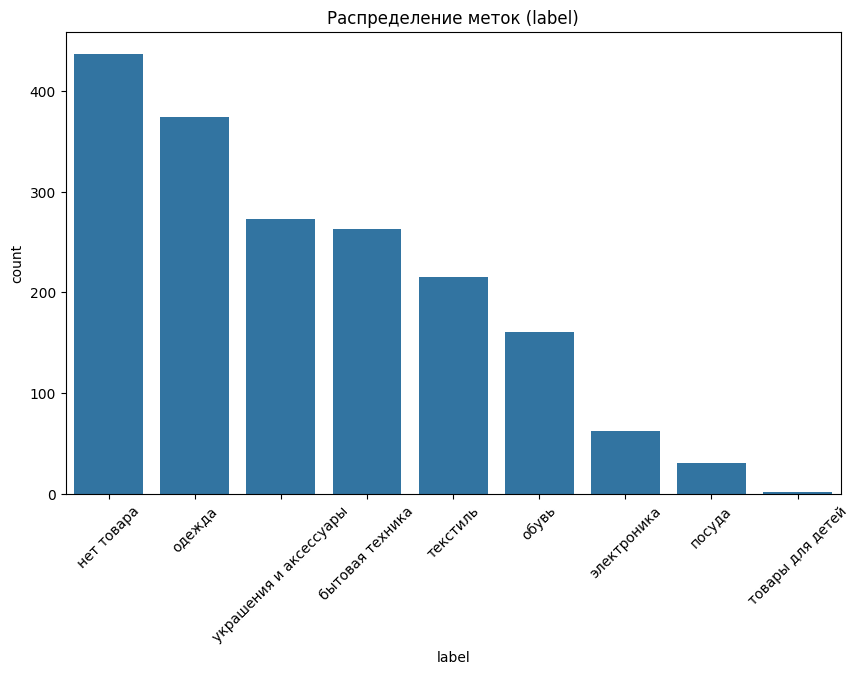

In [ ]:
df = train_zero_shot

plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title("Распределение меток (label)")
plt.xticks(rotation=45)
plt.show()



###Формирование учебного датасета

Изучив zero-shot разметку NLI модели, я приметил несколько моментов:
1. Весь train.csv и test.csv можно было бы определить между двумя категориями: "одежда" и "нет товара", в некоторых случаях с натяжкой можно было бы добавить "текстиль" и "украшения и аксессуары"
2. В исходных файлах есть множество упоминаний конкретных товаров одежды, которые можно использовать для формирования учебного датасета
3. Первые 21 строки из марок "нет товара" - без ошибок.

Таким образом, возникло две идеи.

**Первая** -  про правильное решение задачи, в котором модель должна выбирать из всех категорий.

**Вторая** же о том, чтобы идеально научить модель различать только две категории "нет товара" и "одежда", тогда правильность на финальном тестировании будет максимальная.

Хотелось бы пойти по первому пути, но примеров на другие категории очень мало, а согласно ограничениям, использовать другие источники нельзя. По этой причине выбор пал пойти по второму пути.

In [ ]:
df = train_zero_shot

words_clothes = ["футболка", "майка", "блузка", "юбка", "штаны", "шапка", "свитер", "кофта", "джинсы", "пижама", "трусы", "джемпер", "леггинсы", "носочки", "лиф", "кардиган", "костюм"]

df_train = df[df["text"].str.contains("|".join(words_clothes)) & (df["label"] == "одежда")]

filtered = df[df['label'] == 'нет товара']
top_21 = filtered.head(21)

df = pd.concat([df_train, top_21], ignore_index=True)
df.head()

,text,label,score
0,"заказ получила за 3 недели, трек отслеживался,...",одежда,0.230620
1,"бомбезная шапка,под спортивную одежду -класс,т...",одежда,0.220496
2,футболка понравилась.но я заказывала оранжевую...,одежда,0.205568
3,цифры и буквы на комплекте написаны в зеркаль...,одежда,0.202413
4,кароч я заказала этот товар и он че то долго ...,одежда,0.196791


###Аугментация

Раз уж аугментацию разрешили, то думаю стоит ей воспользоваться. Возьмём простой вариантик с изменением порядка слов, чтобы немного увеличить наш датасет для обучения.

In [ ]:
word_aug = naw.RandomWordAug(action="swap")

aug_texts, aug_labels = [], []

n_aug_per_row = 2

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row["text"])
    label = row["label"]

    aug_texts.append(text)
    aug_labels.append(label)

    for _ in range(n_aug_per_row):
        new_text = word_aug.augment(text)

        if isinstance(new_text, list):
            new_text = " ".join(new_text)
        new_text = str(new_text).replace("[", "").replace("]", "").replace("'", '"').replace('"', "")

        aug_texts.append(new_text.strip())
        aug_labels.append(label)

df = pd.DataFrame({"text": aug_texts, "label": aug_labels})

print("Исходных строк:", len(df), "| После аугментации:", len(df))
df.head()

100%|██████████| 91/91 [00:00<00:00, 2702.96it/s]

Исходных строк: 273 | После аугментации: 273


,text,label
0,"заказ получила за 3 недели, трек отслеживался,...",одежда
1,"заказ получила 3 за недели, отслеживался трек,...",одежда
2,"Получила заказ за 3 недели, трек отслеживался,...",одежда
3,"бомбезная шапка,под спортивную одежду -класс,т...",одежда
4,"шапка бомбезная, спортивную под - одежду класс...",одежда


##Шаг 2: Обучение модели

Остаётся около одного дня на завершение задания. Остаётся дообучить предобученную модель и получить финальные ответы.

Использую стандартное дообучение методом fine-tunning на нашем подготовленном датасете. Модель использую BERT, достаточно популярная для такого типа задач.

In [ ]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['category_encoded'].tolist(),
    test_size=0.2,
    random_state=42
)

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)


train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128
)
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128
)

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to='none'

)

os.environ["WANDB_DISABLED"] = "true"

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()
print("Обучение завершено")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [ ]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

In [ ]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

Модель обучена, сохранена и готова к использованию.

Хотелось бы попробовать различные методы обучения, поэксперементировать с количеством эпох, различными датасетами и различными моделями. Но время ограничено, оставим это для **перспектив**. Пока приоритет на MVP.

##Шаг 3: Финальные тесты

Вот мы и подошли к заключительной части. Дело осталось за малым - разметить test.csv и указать среднюю скорость вычисления.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_model")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_model")
model.eval()

texts = test_data['text'].tolist()
results = []
times = []


for text in tqdm(texts, desc="Обработка отзывов"):
    start_time = time.time()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

    end_time = time.time()
    processing_time = end_time - start_time
    times.append(processing_time)

    results.append({'text': text, 'category': prediction})

output_df = pd.DataFrame(results)
output_df.to_csv('predictions.csv', index=False, encoding='utf-8')

avg_time = sum(times) / len(times)
print(f"Обработано текстов: {len(times)}")
print(f"Среднее время на один запрос: {avg_time:.4f} секунды")
print(f"Результаты сохранены в predictions.csv")

Конечно, меня очень терзают сомнения по поводу моего решения. С одной стороны я не нашёл наличия ни одного примера по другим категориям, кроме "одежда" и "нет товара". Моя гипотеза в том, что это даст отличный результат на F1. Но можно ли было так делать или надо было оставить все категории, просто пусть результат F1 будет хуже.

Тут уже на суд проверяющих

In [ ]:
print("\nРаспределение категорий:")
category_counts = output_df['category'].value_counts()
print(category_counts)

plt.figure(figsize=(12, 5))

# Круговая диаграмма
plt.subplot(1, 2, 1)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение категорий\n(круговая диаграмма)')
plt.axis('equal')

# Столбчатая диаграмма
plt.subplot(1, 2, 2)
category_counts.plot(kind='bar', color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Количество отзывов по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
category_map = {0: "нет товара", 1: "одежда"}
submission_df = pd.DataFrame({'category': output_df['category'].map(category_map)})


submission_df.to_csv('submission.csv', index=False, encoding='utf-8')
print("Файл submission.csv создан")

##Рефлексия

**Цель кейса:** Выполнена частично.

Хотелось бы доделать? Конечно, но возникла спорная ситуация по несбалансированности датасетов

**Ограничения:**
- Внешние API не использовались
- Тестовая выборка только для финальной проверки
- Внешние данные не использовались
- Решение умещается в Google Colab
- Классификация примера меньше 5 секунд

**Плюсы:**
- Автоматическая разметка данных
- Аугментация
- Fine-tunning обучение
- Хороший показатель F1, по крайней мере мне так кажется

##Перспективы

1. Улучшить zero-shot классификацию. Найденная NLI модель справляется хорошо, но изъянов много. Обучать модель на этих размеченных данных дало бы очень плохие результаты
2. Увеличить количество тренировочных данных, сбалансировав их по категориям для более качественного обучения
3. Протестировать различные модели, методы обучения и параметры обучения в поисках лучшего варианта

##Благодарности

**Спасибо** команде Т-банка, Т-образования за такое интересное задание. Благодаря нему я узнал много нового и на теории, на и практике, а это уже **Отлично**!

**Спасибо** тем, кто обратил внимания на этот проект. Надеюсь вы подчерпнули что-то интересное и полезное для себя.

**Счастья Вам и позитива!**